In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import itertools
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
import os
import scipy
import sklearn
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans

In [5]:
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN

In [5]:
effnet = torchvision.models.efficientnet_v2_s(weights='DEFAULT')

In [6]:
effnet_vecotr = nn.Sequential(effnet.features, effnet.avgpool)
effnet_vecotr.cuda()
effnet_vecotr.eval()
pass

In [6]:
def load_images(data):
    
    image_np = list()
    for name,val in data.items():
        img = cv2.imread(f'image/{name}', cv2.IMREAD_UNCHANGED)
        image_np.append(img)


    return np.stack(image_np)
def prepeare_effvec(image_np):
    means = np.array([[0.485, 0.456, 0.406]])[...,np.newaxis,np.newaxis]
    stds = np.array([[0.229, 0.224, 0.225]])[...,np.newaxis,np.newaxis]
    reimagened = np.broadcast_to(np.expand_dims(image_np, axis=1),(image_np.shape[0],3,512,512))
    
    return torch.tensor((reimagened-means)/stds,dtype=torch.float32, device=torch.device('cuda'))

In [7]:
batch_n = 20
with open('train.json') as file:
    all_data = pd.Series(json.load(file))
    data = np.array_split(all_data, batch_n)


## Generate image vectors

In [31]:
for bn in range(batch_n):
    image_np = load_images(data[bn])
    x_effvec = prepeare_effvec(image_np)
    with torch.no_grad():
        img_vecotrs = effnet_vecotr(x_effvec)
    torch.save(img_vecotrs.cpu(), f'vectors/img_vecotrs{bn}.pt')
    print(f'{bn}: {img_vecotrs.shape}')

0: torch.Size([50, 1280, 1, 1])
1: torch.Size([50, 1280, 1, 1])
2: torch.Size([50, 1280, 1, 1])
3: torch.Size([50, 1280, 1, 1])
4: torch.Size([50, 1280, 1, 1])
5: torch.Size([50, 1280, 1, 1])
6: torch.Size([50, 1280, 1, 1])
7: torch.Size([50, 1280, 1, 1])
8: torch.Size([50, 1280, 1, 1])
9: torch.Size([50, 1280, 1, 1])
10: torch.Size([50, 1280, 1, 1])
11: torch.Size([50, 1280, 1, 1])
12: torch.Size([50, 1280, 1, 1])
13: torch.Size([50, 1280, 1, 1])
14: torch.Size([50, 1280, 1, 1])
15: torch.Size([50, 1280, 1, 1])
16: torch.Size([50, 1280, 1, 1])
17: torch.Size([50, 1280, 1, 1])
18: torch.Size([50, 1280, 1, 1])
19: torch.Size([50, 1280, 1, 1])


## Load all vecotrs

In [32]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [43]:
vector_files = os.listdir('vectors')
all_batches = [torch.load(f'vectors/img_vecotrs{vn}.pt') for vn in range(len(vector_files))]
vectors = torch.squeeze(torch.concat(all_batches))

## Calculate pairwise distance

In [48]:
distances = scipy.spatial.distance.pdist(vectors)
matrix = scipy.spatial.distance.squareform(distances)

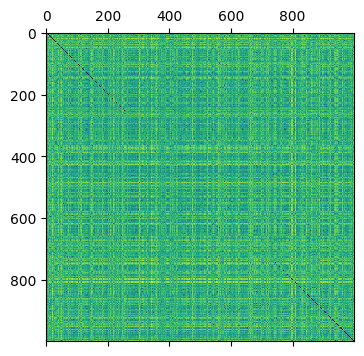

In [58]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.matshow(matrix)
plt.show()

In [69]:
mds = MDS(dissimilarity="precomputed", normalized_stress='auto',n_jobs=10)
image_2d = mds.fit_transform(matrix)

In [112]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto")
clusters_2d = kmeans.fit_predict(image_2d)

## Kmeans based on distance

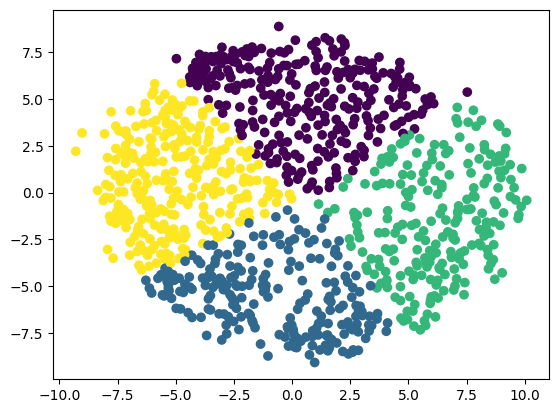

In [113]:
subs = 1000
fig, ax = plt.subplots()
ax.scatter(image_2d[:subs,0],image_2d[:subs,1],c = clusters_2d)
plt.show()

## Density based on distance

In [81]:
trans = np.transpose(image_2d)
z = gaussian_kde(trans)(trans)

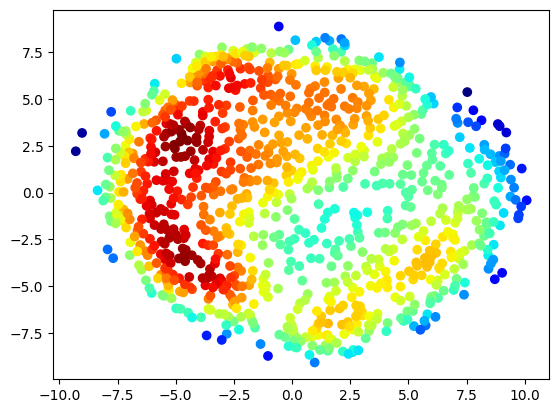

In [83]:
subs = 1000
fig, ax = plt.subplots()
ax.scatter(image_2d[:subs,0],image_2d[:subs,1],c = z, cmap='jet')
plt.show()

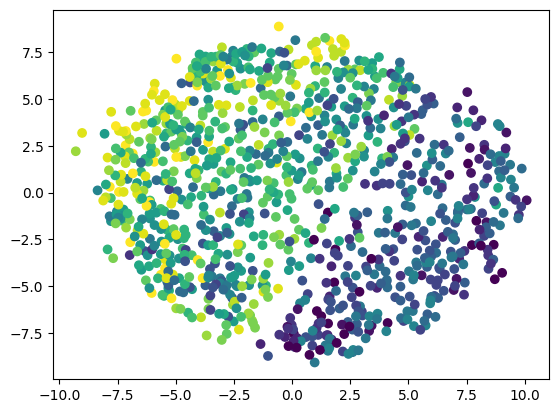

In [117]:
subs = 1000
fig, ax = plt.subplots()
ax.scatter(image_2d[:subs,0],image_2d[:subs,1],c = all_data.values)
plt.show()

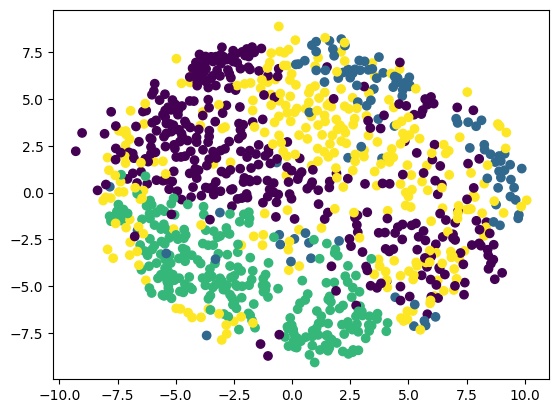

In [124]:
with open('CTImageQuality/analysis/labels.txt') as file:
    patient_lables = pd.Series(np.loadtxt(file.readlines()))
    
subs = 1000
fig, ax = plt.subplots()
ax.scatter(image_2d[:subs,0],image_2d[:subs,1],c = patient_lables.values)
plt.show()

## Vrodnoi

In [97]:
class VornoiMaskGenerator:
    def __init__(self, shape):
        self.x,self.y=shape
        extra_dist=1999
        self._extra_points = [[extra_dist,extra_dist],
                              [-extra_dist,extra_dist], 
                              [extra_dist,-extra_dist], 
                              [-extra_dist,-extra_dist]]
        
    def _make_mask(self, vor):
        polies = list()
        for reg in vor.regions:
            if -1 in reg or len(reg)<3:
                continue
            poly = np.array(vor.vertices)[reg].astype(np.int32)
            polies.append(cv2.fillPoly(np.zeros(shape), pts=[poly], color=1))

        return np.stack(polies)
    
    def __call__(self, sectors):
        xp = np.random.randint(0,self.x,sectors)
        yp = np.random.randint(0,self.y,sectors)
        all_points = np.append(np.stack([xp,yp]).T, self._extra_points, axis=0)
        vor = scipy.spatial.Voronoi(all_points)
        mask = self._make_mask(vor)
        
        assert mask.shape[0]==sectors, 'This class is shit make extra_dist more'
        return mask.astype(np.uint8)
    
mask_gen = VornoiMaskGenerator(img.shape)

In [125]:
class NpDataset(torch.utils.data.Dataset):
    def __init__(self, lables: pd.Series, images: np.ndarray):
        assert lables.shape[0]==images.shape[0], 'Different number of lables and images'
        self.lables=lables
        self.images=images
        self.sz = images.shape[0]
        
    def __getitem__(self, idx):
        return self.images[0]
        
    def __len__(self):
        return self.sz
    
class MaskDataset(NpDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print(self.lables.reset_index().reset_index().groupby(0).apply(np.array))
        
mds = MaskDataset(data[0], few_images)

0
0.0                                 [[8, 0008.tif, 0.0]]
0.2            [[5, 0005.tif, 0.2], [21, 0021.tif, 0.2]]
0.4                                [[29, 0029.tif, 0.4]]
0.6    [[6, 0006.tif, 0.6], [12, 0012.tif, 0.6], [17,...
0.8                                [[33, 0033.tif, 0.8]]
1.0    [[24, 0024.tif, 1.0], [36, 0036.tif, 1.0], [38...
1.2                                [[14, 0014.tif, 1.2]]
1.4    [[18, 0018.tif, 1.4], [26, 0026.tif, 1.4], [35...
1.6    [[9, 0009.tif, 1.6], [20, 0020.tif, 1.6], [34,...
1.8    [[1, 0001.tif, 1.8], [31, 0031.tif, 1.8], [32,...
2.0    [[3, 0003.tif, 2.0], [4, 0004.tif, 2.0], [16, ...
2.2    [[11, 0011.tif, 2.2], [23, 0023.tif, 2.2], [27...
2.4           [[13, 0013.tif, 2.4], [48, 0048.tif, 2.4]]
2.8    [[0, 0000.tif, 2.8], [41, 0041.tif, 2.8], [49,...
3.2           [[30, 0030.tif, 3.2], [42, 0042.tif, 3.2]]
3.4            [[2, 0002.tif, 3.4], [43, 0043.tif, 3.4]]
3.6                                [[19, 0019.tif, 3.6]]
3.8           [[22, 0022.tif,

In [101]:
all_data.shape

(1000,)

In [99]:
few_images.shape

(50, 512, 512)

In [98]:
mask_gen(10).dtype

dtype('uint8')

In [86]:
few_images = load_images(data[0])

In [78]:
for i in range(10):
    vor = random_split(img.shape, 5)
    mask = get_mask(vor,img.shape)
    print(mask.shape)

(5, 512, 512)
(5, 512, 512)
(5, 512, 512)
(5, 512, 512)
(5, 512, 512)
(5, 512, 512)
(5, 512, 512)
(5, 512, 512)
(5, 512, 512)
(5, 512, 512)


In [45]:
def random_split(shape, sectors):
    x,y = shape
    ext_pnt = 1999
    xp = np.random.randint(0,x,sectors)
    yp = np.random.randint(0,y,sectors)
    random_points = np.stack([xp,yp]).T
    extra_points = np.append(random_points, [[ext_pnt,ext_pnt], [-ext_pnt,ext_pnt], [ext_pnt,-ext_pnt], [-ext_pnt,-ext_pnt]], axis=0)
    vor = scipy.spatial.Voronoi(extra_points)
    return vor
img = few_images[0]
vor = random_split(img.shape, 5)

In [82]:
def get_mask(vor, shape):
    polies = list()
    for reg in vor.regions:
        if -1 in reg or not len(reg):
            continue
        poly = np.array(vor.vertices)[reg].astype(np.int32)
        polies.append(cv2.fillPoly(np.zeros(shape), pts=[poly], color=1))
        
    return np.stack(polies)
mask = get_mask(vor,img.shape)

In [83]:
np.unique(mask)

array([0., 1.])

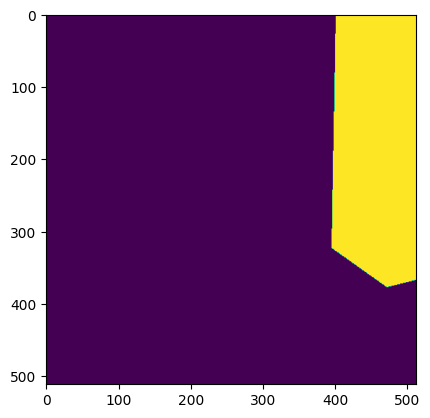

In [72]:
plt.imshow(mask[4])

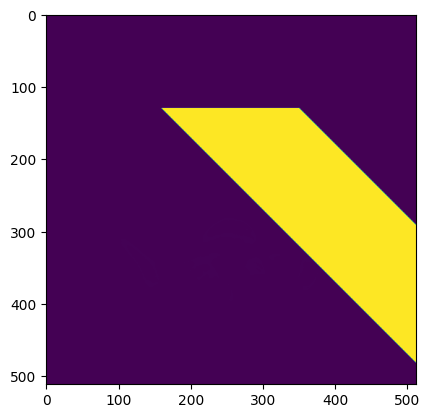

In [44]:
img = np.copy(few_images[1])

points = np.array([[160, 130], [350, 130], [6000000, 6000000]])
filled = cv2.fillPoly(img, pts=[points], color=(255, 0, 0))


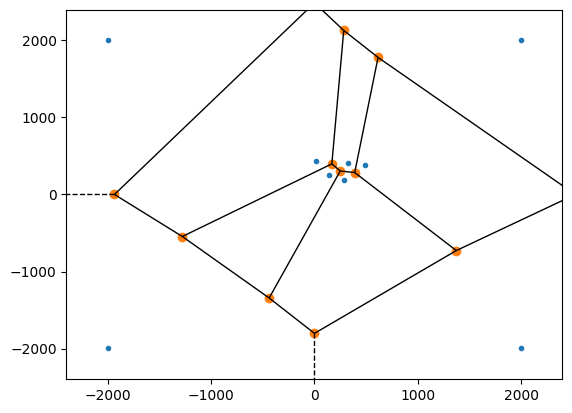

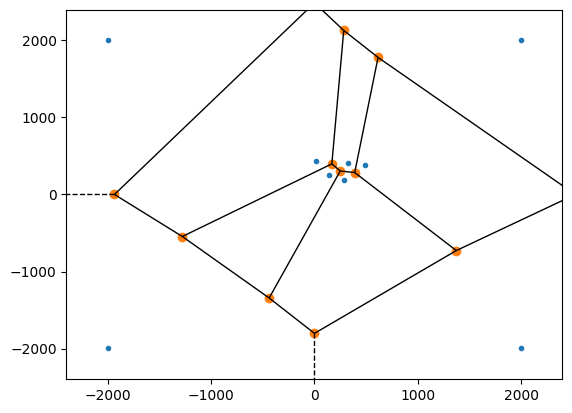

In [79]:
scipy.spatial.voronoi_plot_2d(vor)

## Loss function

In [8]:
total_pred = all_data.values
from scipy.stats import pearsonr, spearmanr, kendalltau


In [39]:
noise = np.random.uniform(-0.3,0.3,total_pred.shape)
total_gt = np.around(np.copy(total_pred)+noise, 100)
# total_gt.fill(0.33)
# np.random.shuffle(total_gt)

# total_gt = np.random.rand(*total_gt.shape)

print(total_pred[:10])
print(total_gt[:10])

[2.8 1.8 3.4 2.  2.  0.2 0.6 4.  0.  1.6]
[ 2.6910354   1.59155154  3.33190357  2.20954994  2.02579218  0.16807782
  0.56031209  3.86370447 -0.2310643   1.48489226]


In [38]:
aggregate_results=dict()
aggregate_results["plcc"] = abs(pearsonr(total_pred, total_gt)[0])
aggregate_results["srocc"] = abs(spearmanr(total_pred, total_gt)[0])
aggregate_results["krocc"] = abs(kendalltau(total_pred, total_gt)[0])
aggregate_results["overall"] = abs(pearsonr(total_pred, total_gt)[0]) + abs(spearmanr(total_pred, total_gt)[0]) + abs(kendalltau(total_pred, total_gt)[0])
aggregate_results

{'plcc': 0.9862854450447197,
 'srocc': 0.9874983575020614,
 'krocc': 0.9265219765092201,
 'overall': 2.9003057790560014}

In [40]:
aggregate_results=dict()
aggregate_results["plcc"] = abs(pearsonr(total_pred, total_gt)[0])
aggregate_results["srocc"] = abs(spearmanr(total_pred, total_gt)[0])
aggregate_results["krocc"] = abs(kendalltau(total_pred, total_gt)[0])
aggregate_results["overall"] = abs(pearsonr(total_pred, total_gt)[0]) + abs(spearmanr(total_pred, total_gt)[0]) + abs(kendalltau(total_pred, total_gt)[0])
aggregate_results

{'plcc': 0.9874674855606965,
 'srocc': 0.9883444931289761,
 'krocc': 0.9201629016044475,
 'overall': 2.89597488029412}

In [5]:
all_data

0000.tif    2.8
0001.tif    1.8
0002.tif    3.4
0003.tif    2.0
0004.tif    2.0
           ... 
0995.tif    2.6
0996.tif    2.2
0997.tif    3.8
0998.tif    1.2
0999.tif    1.8
Length: 1000, dtype: float64

In [122]:
scipy.spatial.Voronoi()

0      2.0
1      2.0
2      2.0
3      2.0
4      3.0
      ... 
995    0.0
996    2.0
997    3.0
998    1.0
999    3.0
Length: 1000, dtype: float64

In [53]:
matrix.std()

1.501225147936316

In [63]:
image = pd.Series(data)

In [56]:
image_np.shape

(1000, 512, 512)

In [67]:
imagesdf = pd.DataFrame(image)
imagesdf['mean'] = image_np.mean(axis=(1,2))
imagesdf['std'] = image_np.std(axis=(1,2))
imagesdf.groupby(['0'])

KeyError: '0'

In [70]:
imagesdf.groupby([0]).mean()

mean       std
0                      
0.0  0.312291  0.342005
0.2  0.369131  0.335696
0.4  0.360827  0.335592
0.6  0.375846  0.337624
0.8  0.352396  0.337324
1.0  0.346487  0.336869
1.2  0.366668  0.337308
1.4  0.381915  0.338058
1.6  0.367072  0.338590
1.8  0.370114  0.338297
2.0  0.347393  0.337931
2.2  0.360198  0.337190
2.4  0.381583  0.338345
2.6  0.362486  0.336305
2.8  0.369984  0.340243
3.0  0.393815  0.340082
3.2  0.382921  0.336469
3.4  0.371619  0.339402
3.6  0.387834  0.344246
3.8  0.356973  0.339313
4.0  0.348120  0.339385

In [97]:
class WiredNormalize:
    def __init__(self, image_np):
        self.crops = 25 
        self.mean = self.crop(image_np.mean(axis=0))
        self.std = self.crop(image_np.std(axis=0))
        
    def crop(self, img):
        return img[self.crops:-self.crops,self.crops:-self.crops]
    
    def __call__(self, img):
        return (self.crop(img)-self.mean)/self.std

wired_normalize = WiredNormalize(image_np)

In [98]:
wired_normalize(image_np[0])

array([[-0.1339313 , -0.13486087, -0.15349548, ..., -0.13284534,
        -0.10725817, -0.06286362],
       [-0.09088667, -0.13921483, -0.12979536, ..., -0.09706821,
        -0.08576908, -0.07740217],
       [-0.09700862, -0.09133499, -0.10419422, ..., -0.06501267,
        -0.1032891 , -0.08189484],
       ...,
       [-0.28041452, -0.4088646 , -0.3589063 , ...,  2.691211  ,
        -0.2246474 , -0.2289777 ],
       [-0.30529115,  1.051362  , -0.4264663 , ..., -0.248839  ,
        -0.24916957,  0.5923548 ],
       [-0.32063314, -0.39110574,  0.75547487, ...,  1.1677848 ,
        -0.4247917 , -0.39070785]], dtype=float32)

In [60]:
image_np.mean(axis=(1,2)).shape

(1000,)

/tmp/ipykernel_54722/1598089815.py:3: RuntimeWarning: invalid value encountered in divide
  wired_normalize = lambda x: (x-mean)/std


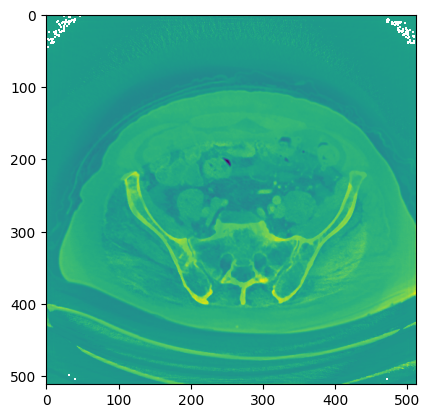

In [87]:
img = cv2.imread('image/0801.tif', cv2.IMREAD_UNCHANGED)
ax = plt.subplot()

ax.imshow(wired_normalize(img))
plt.show()

In [44]:
img.std()

0.32240248

In [26]:
image.value_counts().sort_index()

0.0    25
0.2    19
0.4    22
0.6    42
0.8    48
1.0    56
1.2    51
1.4    65
1.6    65
1.8    74
2.0    53
2.2    56
2.4    60
2.6    62
2.8    42
3.0    65
3.2    35
3.4    42
3.6    31
3.8    51
4.0    36
Name: count, dtype: int64

In [33]:
image.sort_values(ascending=False)[33:]

0837.tif    4.0
0412.tif    4.0
0870.tif    4.0
0397.tif    3.8
0456.tif    3.8
           ... 
0967.tif    0.0
0670.tif    0.0
0943.tif    0.0
0708.tif    0.0
0791.tif    0.0
Length: 967, dtype: float64

('0468.tif', 0.2)

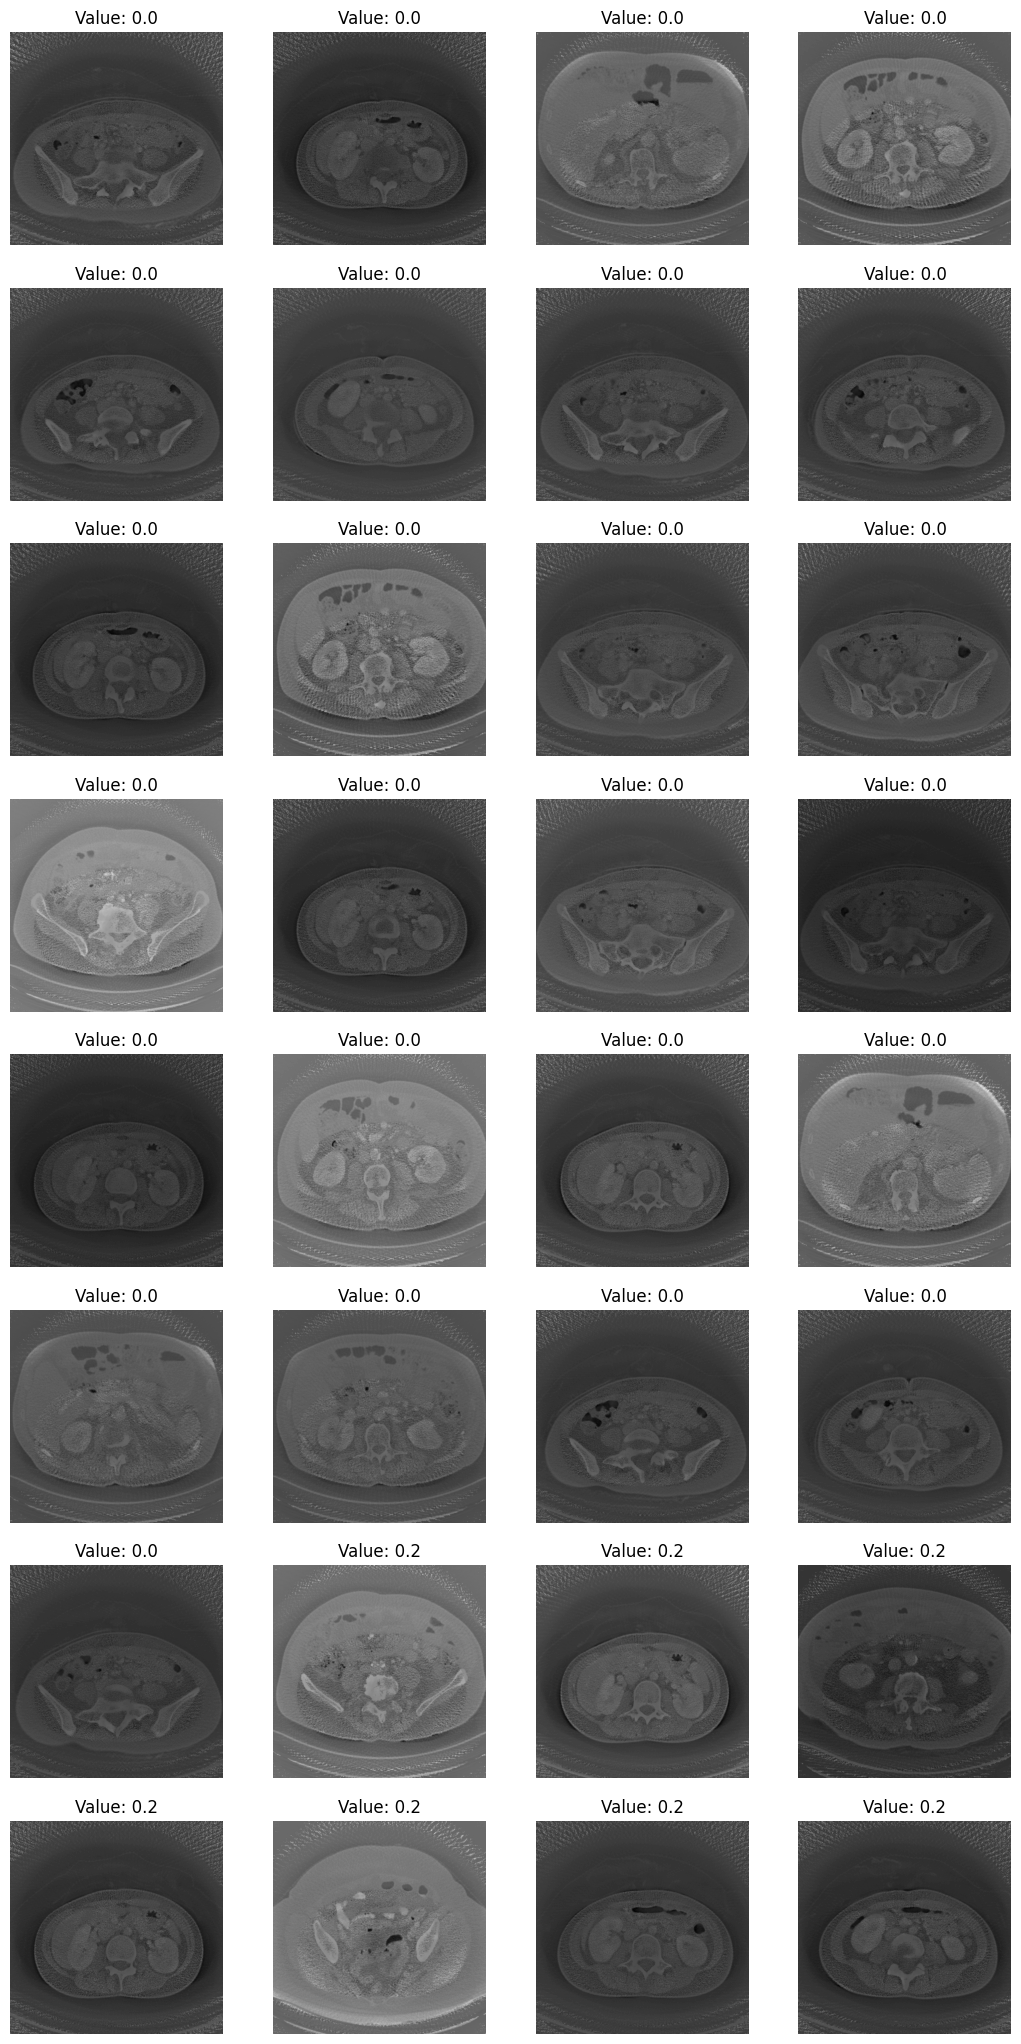

In [99]:
fig, ax = plt.subplots(8,4, figsize=(13,26))
tops = iter(image.sort_values(ascending=True).items())
for axi in itertools.chain(*ax):
    
    name, value = next(tops)
    img = cv2.imread(f'image/{name}', cv2.IMREAD_UNCHANGED)
    img = wired_normalize(img)
    axi.imshow(img, cmap='gray')
    axi.axis('off')
    axi.set_title(f'Value: {value}')
plt.savefig('bad.png')
next(tops)

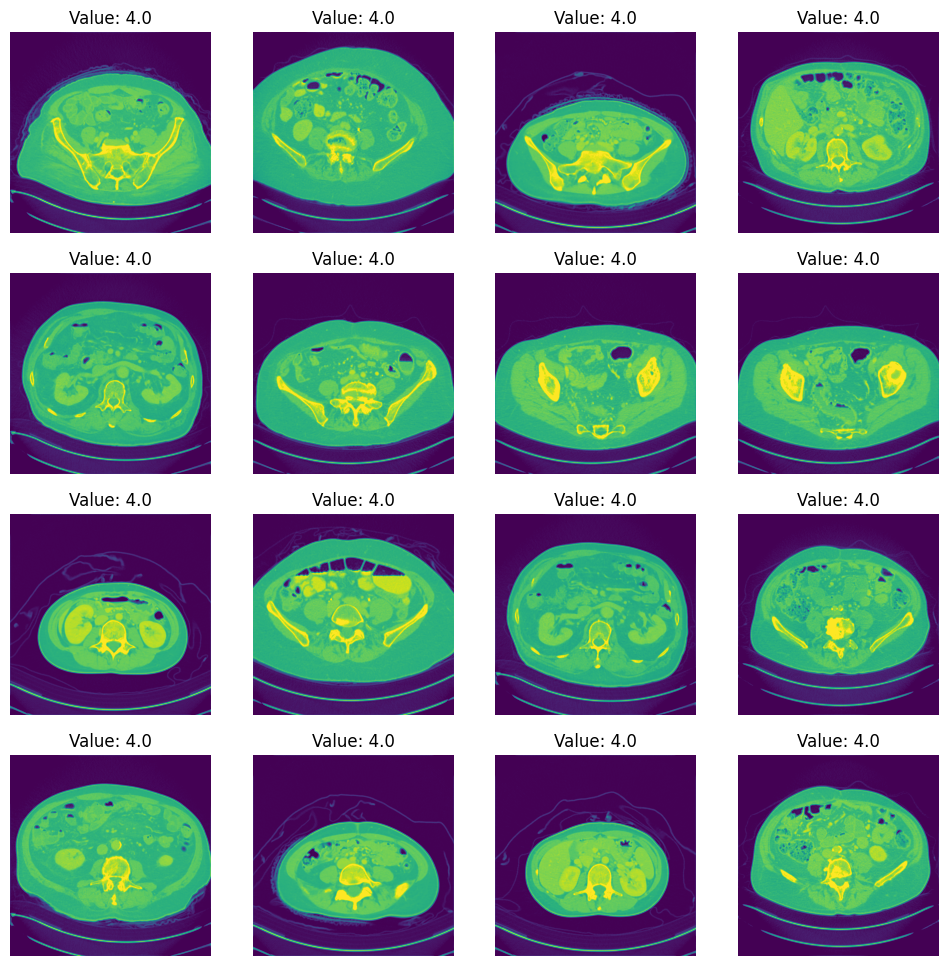

In [41]:
fig, ax = plt.subplots(4,4, figsize=(12,12))
tops = iter(image.sort_values(ascending=False).items())
for axi in itertools.chain(*ax):
    
    name, value = next(tops)
    img = cv2.imread(f'image/{name}', cv2.IMREAD_UNCHANGED)
    axi.imshow(img)
    axi.axis('off')
    axi.set_title(f'Value: {value}')
plt.show()